For Wednesday: 
-leave in XGBoost with just wind speed 
-We know the before values 
-run this model when next hurricane hits and validate it against the data 
-run it on hurricane ian data 
-run it with just size rank to just see if it substantially drops 
-compare F1 score of SizeRank and Wind Speed to see how much information is being added 




# Obtaining Data

In [1]:
#Importing libraries needed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# For demonstrative pruposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

In [2]:
#opening the datasets 
bottom =  pd.read_csv(r'data\bottom_hurricane.csv')
middle =  pd.read_csv(r'data\middle_hurricane.csv')
top =  pd.read_csv(r'data\top_hurricane.csv')
all = pd.read_csv(r'data\all_hurricane.csv')

In [3]:
all

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
2,Apalachicola,dennis,7/11/2005,38.027300,71.58080,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
4,Apalachicola,irma,9/10/2017,42.523469,71.58080,12877,52379.75722,63594.00344,21.409504,1
...,...,...,...,...,...,...,...,...,...,...
1188,West Palm Beach,matthew,10/7/2016,44.044561,69.56759,158,375111.31040,393070.81160,4.787779,0
1189,West Palm Beach,matthew,10/8/2016,23.509819,38.02730,158,375111.31040,393070.81160,4.787779,0
1190,West Palm Beach,michael,10/11/2018,15.501717,38.02730,158,414414.18150,434088.96000,4.747612,0
1191,West Palm Beach,michael,10/10/2018,28.520475,56.14619,158,414414.18150,434088.96000,4.747612,0


In [4]:
#let's get rid of duplicate cities by only grabbing the cities with the max value for AWND
bottom = bottom.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
middle = middle.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
top = top.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
all = all.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City', 'DATE']).sort_index()

In [5]:
bottom

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,65287.07867,76710.34737,17.496982,1
...,...,...,...,...,...,...,...,...,...,...
388,West Palm Beach,michael,10/9/2018,30.533685,51.44870,158,131859.03710,143536.42570,8.855964,0
389,Winter Haven,dennis,7/10/2005,30.533685,56.14619,395,59886.01537,76763.92735,28.183395,0
392,Winter Haven,irma,9/10/2017,58.047555,123.02950,395,80030.41335,93036.50736,16.251439,1
394,Winter Haven,matthew,10/7/2016,30.019198,57.93571,395,69267.39054,80862.30360,16.739353,1


In [6]:
middle

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,91915.39335,114408.1491,24.471152,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,112287.89680,140227.0087,24.881677,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,127923.42670,142053.1799,11.045477,0
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,124938.95560,128831.4366,3.115506,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,144565.87220,161515.9275,11.724797,1
...,...,...,...,...,...,...,...,...,...,...
381,West Palm Beach,charley,8/13/2004,28.520475,69.56759,158,156234.53760,191100.1557,22.316204,0
383,West Palm Beach,dennis,7/10/2005,35.521972,78.06781,158,187824.49660,240703.5672,28.153447,0
386,West Palm Beach,irma,9/10/2017,87.060148,147.63540,158,214427.89250,234149.5014,9.197315,0
388,West Palm Beach,matthew,10/7/2016,44.044561,69.56759,158,197641.97590,216511.5252,9.547339,0


In [7]:
top

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,221794.3003,275297.2698,24.122788,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,269923.5452,339439.8016,25.754054,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,257605.2886,276477.8214,7.326143,0
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,255217.2827,259168.4086,1.548142,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,279871.2479,308859.8100,10.357821,1
...,...,...,...,...,...,...,...,...,...,...
389,West Palm Beach,charley,8/13/2004,28.520475,69.56759,158,337513.4241,408594.3455,21.060176,0
391,West Palm Beach,dennis,7/10/2005,35.521972,78.06781,158,401684.3542,509416.8784,26.820194,0
394,West Palm Beach,irma,9/10/2017,87.060148,147.63540,158,390818.9715,413213.8804,5.730251,0
396,West Palm Beach,matthew,10/7/2016,44.044561,69.56759,158,375111.3104,393070.8116,4.787779,0


In [8]:
all

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
4,Apalachicola,irma,9/10/2017,42.523469,71.58080,12877,52379.75722,63594.00344,21.409504,1
5,Apalachicola,irma,9/9/2017,29.012593,44.51431,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
9,Apalachicola,michael,10/9/2018,29.527080,46.97490,12877,65287.07867,76710.34737,17.496982,1
...,...,...,...,...,...,...,...,...,...,...
1175,Vero Beach,irma,9/9/2017,36.036459,67.10700,350,388826.87870,415861.76700,6.952937,0
1176,Vero Beach,matthew,10/7/2016,55.542227,123.02950,350,370610.35240,391912.10820,5.747750,0
1178,Vero Beach,michael,10/11/2018,23.509819,40.48789,350,417970.89410,434714.67370,4.005968,0
1181,West Palm Beach,charley,8/13/2004,28.520475,69.56759,158,337513.42410,408594.34550,21.060176,0


## Checking Crosstabs

### Bottom Tier Home Values

In [9]:
#check crosstabs 
bottom[bottom['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,37.643299,70.658079,778.479167,95519.992225,109226.353419,15.737500,0.0
std,16.800257,31.050273,1933.043703,36589.222256,38580.694737,7.428945,0.0
min,10.513430,0.000000,12.000000,35072.914710,42936.584540,1.715556,0.0
25%,28.520475,51.448700,109.000000,67085.771493,77117.054463,9.294061,0.0
50%,32.278467,60.284455,219.000000,87921.154230,106197.766650,13.545954,0.0
75%,43.530074,80.528400,714.000000,124777.238250,137188.222700,21.427859,0.0
max,90.057594,176.715100,12877.000000,187941.971100,204898.395000,31.148843,0.0


In [10]:
#check crosstabs 
bottom[bottom['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0
mean,44.089299,81.333684,1614.733333,81869.675339,99918.350911,22.208175,1.0
std,16.901994,31.479745,3251.236781,22972.899025,28216.775660,6.973273,0.0
min,13.018758,29.079700,12.000000,33025.679010,41196.088340,12.376811,1.0
25%,31.025803,57.935710,105.000000,65732.062590,78209.741850,17.496982,1.0
50%,43.530074,69.567590,350.000000,79706.029380,97547.957590,19.823318,1.0
75%,53.036899,116.542490,1343.000000,94132.640630,113361.292200,24.912005,1.0
max,91.064199,158.596210,12877.000000,137614.499600,166366.441400,38.720009,1.0


### Middle Tier Home Values

In [11]:
#check crosstabs 
middle[middle['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0
mean,38.458431,72.874403,1196.764151,178788.700647,200015.445600,12.739620,0.0
std,16.550277,29.720473,2875.059325,57253.054213,60012.616564,8.166830,0.0
min,10.513430,22.592690,12.000000,47433.413480,55475.026340,-0.304135,0.0
25%,28.520475,53.461910,106.000000,140195.814075,158385.796575,6.516116,0.0
50%,33.016644,65.093790,219.000000,168077.713500,188779.652850,10.175417,0.0
75%,45.912372,82.541610,744.000000,214175.896200,235810.160275,19.340890,0.0
max,87.060148,176.715100,12877.000000,328091.109800,346404.378100,30.423110,0.0


In [12]:
#check crosstabs 
middle[middle['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,43.548376,76.359632,2376.212121,152609.677086,183012.972018,19.750077,1.0
std,20.249049,35.454592,3966.086317,45215.695236,58301.939354,9.054438,0.0
min,9.998943,18.118890,12.000000,38971.285380,48205.342730,8.693131,1.0
25%,30.533685,53.461910,299.000000,131341.028200,147305.080700,11.724797,1.0
50%,37.535182,65.093790,529.000000,153995.650000,185899.410500,14.943632,1.0
75%,55.050109,103.121090,1644.000000,184197.828400,211150.410200,27.524342,1.0
max,91.064199,158.596210,12877.000000,237636.125500,316361.491800,34.925821,1.0


### Top Tier Home Values

In [13]:
#check crosstabs 
top[top['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0
mean,39.736174,73.878528,1225.184211,328449.969281,360988.239664,10.473163,0.0
std,17.565823,31.217781,2961.979981,113947.912364,122569.498236,8.631772,0.0
min,9.998943,0.000000,12.000000,98118.000900,119490.997200,-4.161603,0.0
25%,29.012593,53.461910,93.000000,246799.050675,271226.589675,4.737962,0.0
50%,33.777190,65.093790,190.000000,315968.313150,350767.209850,5.958488,0.0
75%,46.527520,85.002200,744.000000,382389.195500,418708.970725,17.504185,0.0
max,90.057594,176.715100,12877.000000,671004.028700,768214.341700,27.655345,0.0


In [14]:
#check crosstabs 
top[top['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,39.423765,72.012202,2354.142857,273379.316779,326346.226943,18.132019,1.0
std,17.008282,32.354927,3809.242403,76774.203448,110181.403979,10.229255,0.0
min,13.018758,29.079700,16.000000,130756.896600,140391.373400,6.722834,1.0
25%,29.398458,52.958607,299.000000,231229.432300,255309.653800,7.967553,1.0
50%,33.273888,62.633200,636.500000,252692.063600,311156.525200,18.205906,1.0
75%,49.038440,76.781592,1927.000000,315217.170000,372749.758575,28.046185,1.0
max,91.064199,158.596210,12877.000000,457389.673300,605350.754900,33.863819,1.0


### All Home Values 

In [15]:
#check crosstabs 
all[all['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.0
mean,30.925011,60.731396,1089.431373,211747.767169,233408.265102,11.845164,0.0
std,15.293820,27.899548,2694.309919,123184.553376,132296.698262,8.187838,0.0
min,6.509379,0.000000,12.000000,35072.914710,42936.584540,-4.161603,0.0
25%,19.763011,40.487890,106.000000,124794.712500,140227.008700,5.646389,0.0
50%,27.513870,53.461910,219.000000,187824.496600,214674.751400,9.022159,0.0
75%,37.535182,69.567590,744.000000,273060.916100,295327.216450,17.328141,0.0
max,87.060148,176.715100,12877.000000,638691.713200,768214.341700,30.676022,0.0


In [16]:
#check crosstabs 
all[all['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0
mean,32.844478,62.633200,2131.494382,152594.353036,181933.349527,19.095580,1.0
std,16.774794,29.838443,3717.355567,86637.294646,108333.418143,8.441306,0.0
min,11.005548,15.434610,12.000000,44457.567490,55432.846820,6.722834,1.0
25%,19.505768,40.487890,113.000000,80030.413350,97547.957590,11.991988,1.0
50%,29.527080,56.146190,529.000000,131778.204300,156779.957100,17.496982,1.0
75%,42.523469,71.580800,1644.000000,196585.356400,236701.273600,24.037927,1.0
max,91.064199,158.596210,12877.000000,457389.673300,605350.754900,38.720009,1.0


### Examining Class Imbalance

|dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|bottom tier| 45 | 96| 68% |
|middle tier| 33 | 106 | 76% |
|top tier| 28 | 114 | 80% |
|all| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

0    96
1    45
Name: increase, dtype: int64
majority percent is 68.08510638297872 %


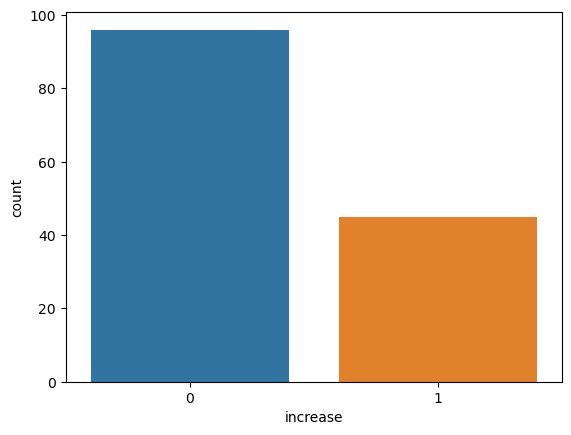

In [17]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom);
print(bottom['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(bottom['increase']) - bottom['increase'].sum())/(len(bottom['increase']) - bottom['increase'].sum()+bottom['increase'].sum())*100
print("majority percent is {}".format(percent),"%")


#### Middle Tier Class Imbalance

0    106
1     33
Name: increase, dtype: int64
majority percent is 76.2589928057554 %


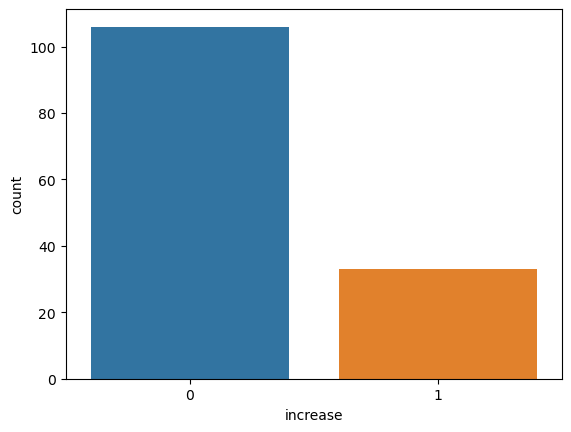

In [18]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=middle);
print(middle['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(middle['increase']) - middle['increase'].sum())/(len(middle['increase']) - middle['increase'].sum()+middle['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

#### Top Tier Class Imbalance

0    114
1     28
Name: increase, dtype: int64
majority percent is 80.28169014084507 %


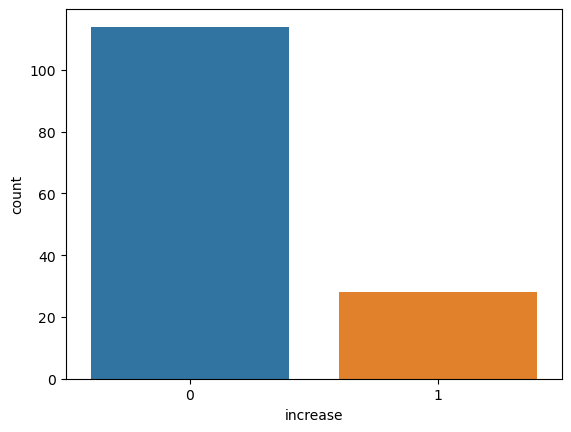

In [19]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=top);
print(top['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(top['increase']) - top['increase'].sum())/(len(top['increase']) - top['increase'].sum()+top['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### All Homes Class Imbalance

0    255
1     89
Name: increase, dtype: int64
majority percent is 74.12790697674419 %


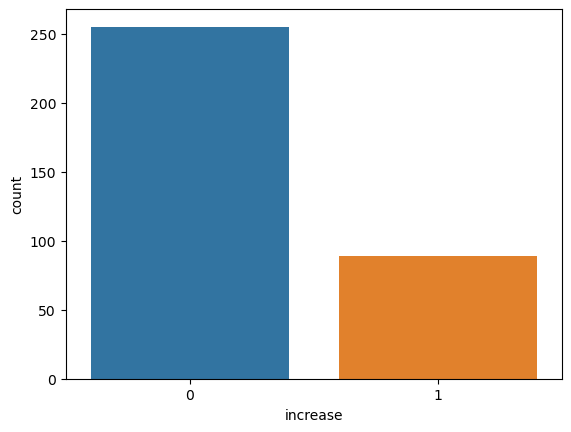

In [20]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=all);
print(all['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all['increase']) - all['increase'].sum())/(len(all['increase']) - all['increase'].sum()+all['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

# Logistic Regression

In [21]:
#establishing model 
logreg = LogisticRegression(random_state=56)

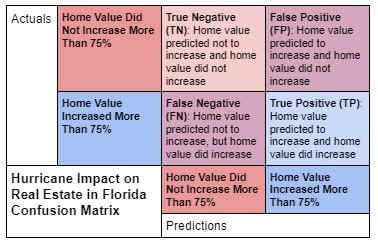

## Model 1: Bottom Tier Housing

We will use the bottom tier housing for modeling since it has the best class imbalance. 

In [22]:
bottom.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,65287.07867,76710.34737,17.496982,1


### Selecting Our Target Variable and Features
Our targer variable is increase and for our first iteration of modeling we will use all the available features. 

In [23]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [24]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Training Data

In [25]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [26]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.673


In [27]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.360


### Testing Data

In [28]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [29]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_test))

Accuracy: 0.767


In [30]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_test, y_pred_test))

F1 Score: 0.500


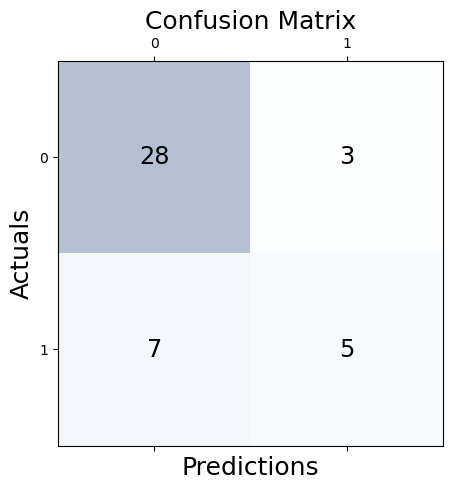

In [31]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

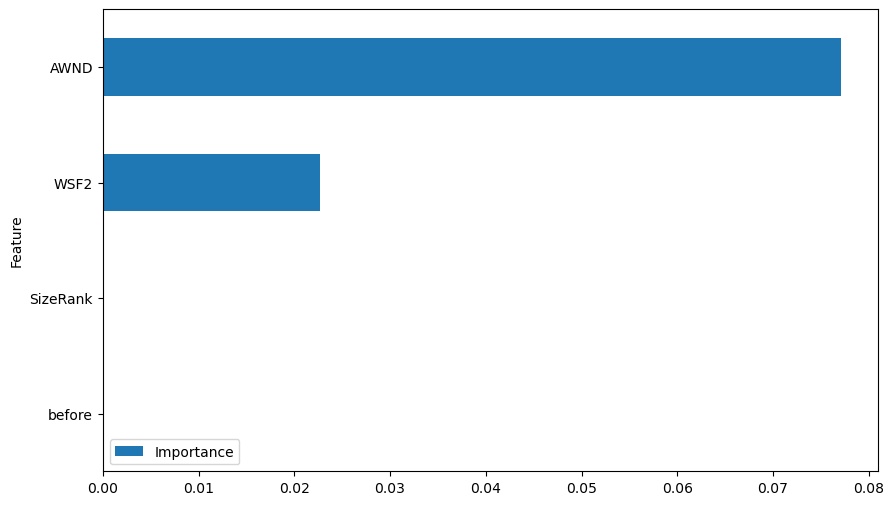

In [32]:
#https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression
#checking out feature importance

model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Model 2: Bottom Tier Housing Without Colinear Variables 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

In [33]:
bottom.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,65287.07867,76710.34737,17.496982,1


### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [34]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [35]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Training Data

In [36]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [37]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.663


In [38]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.298


### Testing Data

In [39]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [40]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_test))

Accuracy: 0.791


In [41]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_test, y_pred_test))

F1 Score: 0.526


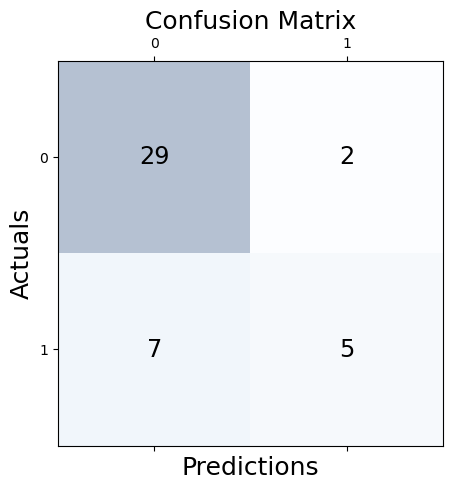

In [42]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

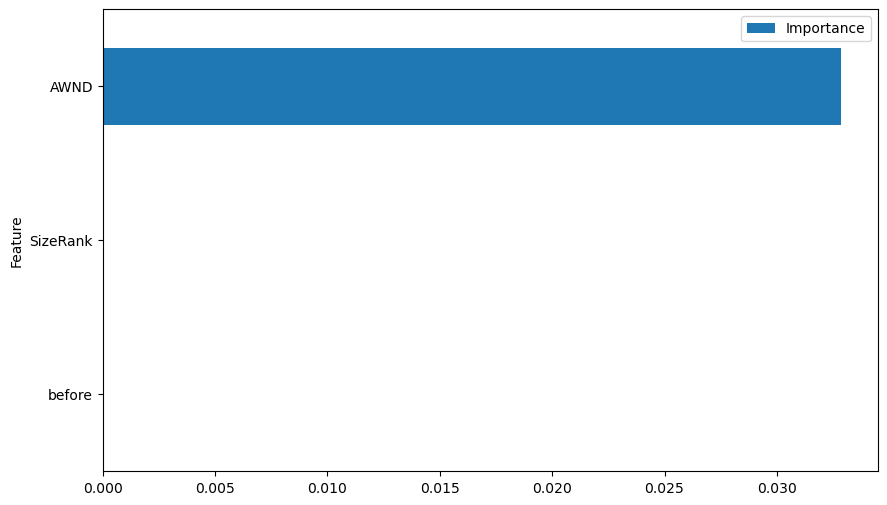

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Model 3: Bottom Tier Housing Without Colinear Variables and Scaling 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

In [44]:
bottom.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,65287.07867,76710.34737,17.496982,1


### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [45]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [46]:
#how do i know if it's even?
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

In [47]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Training Data

In [48]:
#fitting the model unto our training data
logreg.fit(X_train_std, y_train)
y_pred_train = logreg.predict(X_train_std)

In [49]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [50]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [51]:
#fitting the model unto our test data
logreg.fit(X_test_std, y_test)
y_pred_test = logreg.predict(X_test_std)

In [52]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_test))

Accuracy: 0.767


In [53]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_test, y_pred_test))

F1 Score: 0.375


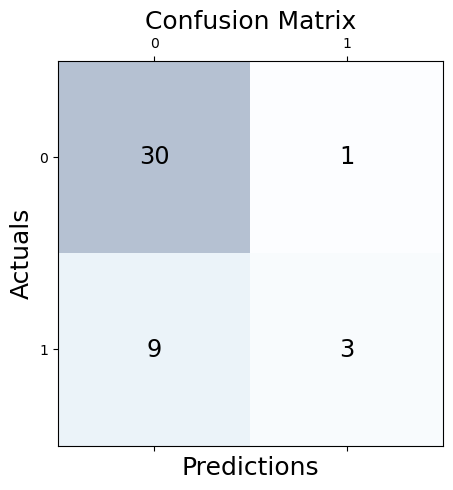

In [54]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

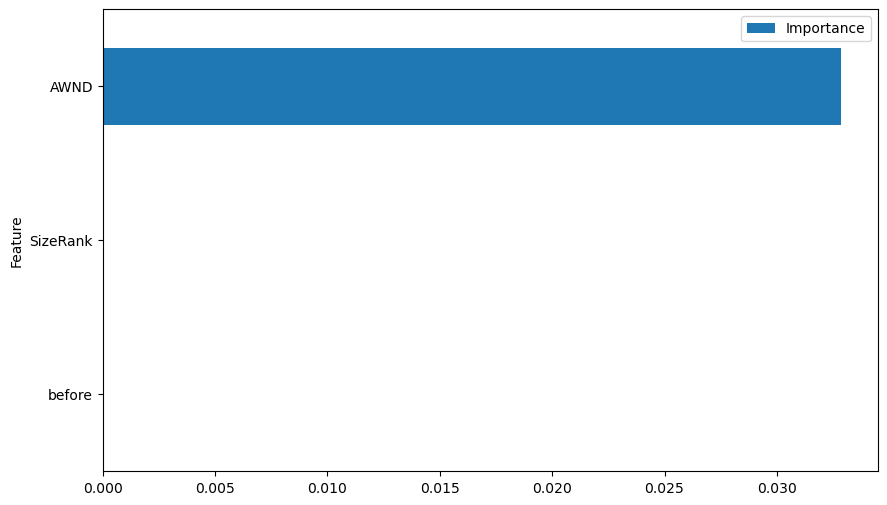

In [55]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Model 4: Bottom Tier Housing With No Scaling, No Colinear Variables, and Smote

In [56]:
bottom

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,65287.07867,76710.34737,17.496982,1
...,...,...,...,...,...,...,...,...,...,...
388,West Palm Beach,michael,10/9/2018,30.533685,51.44870,158,131859.03710,143536.42570,8.855964,0
389,Winter Haven,dennis,7/10/2005,30.533685,56.14619,395,59886.01537,76763.92735,28.183395,0
392,Winter Haven,irma,9/10/2017,58.047555,123.02950,395,80030.41335,93036.50736,16.251439,1
394,Winter Haven,matthew,10/7/2016,30.019198,57.93571,395,69267.39054,80862.30360,16.739353,1


In [57]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [58]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

In [59]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE(random_state=56)

In [60]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [61]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

Before Smote
 0    65
1    33
Name: increase, dtype: int64

After Smote
 1    65
0    65
Name: increase, dtype: int64


### Training Data

In [62]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

In [63]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

Accuracy: 0.638


In [64]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

F1 Score: 0.636


### Testing Data

In [65]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

In [66]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_test, y_pred_test))

Accuracy: 0.758


In [67]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_test, y_pred_test))

F1 Score: 0.737


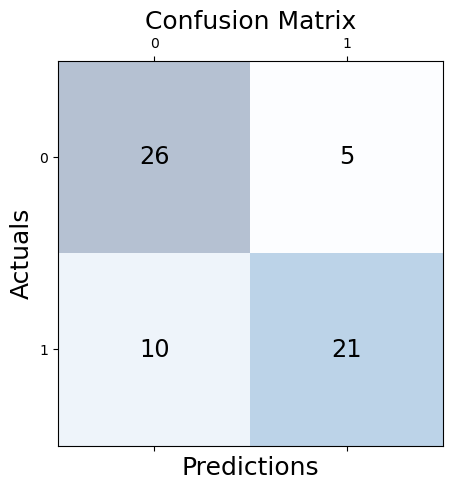

In [68]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=SMOTE_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

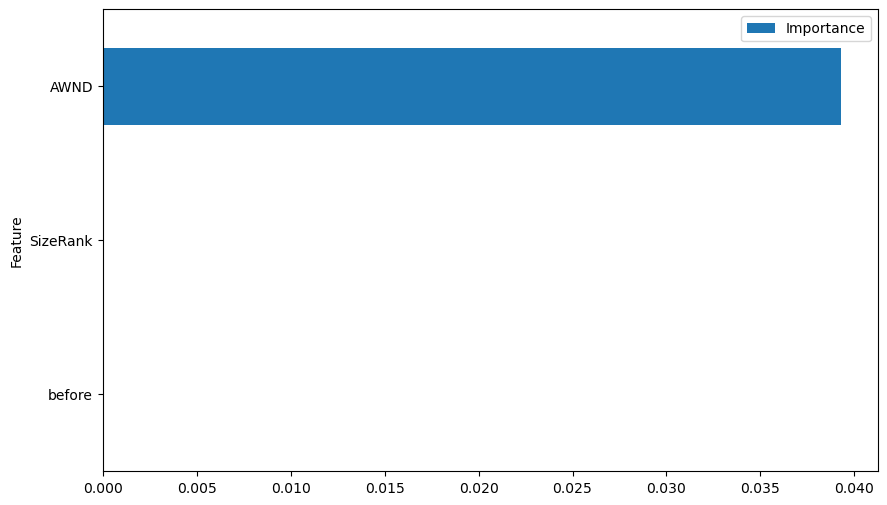

In [69]:
model = LogisticRegression()
model.fit(SMOTE_X_train, SMOTE_y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## XGBoost

In [70]:
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
xgb = xgb.XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [71]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)
#X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase', 'SizeRank', 'before'], axis=1)

In [72]:
bottom

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,13.018758,29.07970,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,43.530074,67.10700,12877,40369.46137,50891.84431,26.065205,0
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
8,Apalachicola,michael,10/10/2018,66.547775,141.14839,12877,65287.07867,76710.34737,17.496982,1
...,...,...,...,...,...,...,...,...,...,...
388,West Palm Beach,michael,10/9/2018,30.533685,51.44870,158,131859.03710,143536.42570,8.855964,0
389,Winter Haven,dennis,7/10/2005,30.533685,56.14619,395,59886.01537,76763.92735,28.183395,0
392,Winter Haven,irma,9/10/2017,58.047555,123.02950,395,80030.41335,93036.50736,16.251439,1
394,Winter Haven,matthew,10/7/2016,30.019198,57.93571,395,69267.39054,80862.30360,16.739353,1


In [73]:
X_boost

,AWND,SizeRank,before
0,13.018758,12877,33025.67901
1,43.530074,12877,40369.46137
3,46.527520,12877,52379.75722
6,24.024306,12877,48548.85811
8,66.547775,12877,65287.07867
...,...,...,...
388,30.533685,158,131859.03710
389,30.533685,395,59886.01537
392,58.047555,395,80030.41335
394,30.019198,395,69267.39054


In [74]:
#performing train test split 
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

In [75]:
xgb.fit(XG_X_train, XG_y_train);

In [76]:
XG_y_train

397    1
360    1
73     1
10     0
316    1
      ..
301    0
54     0
269    0
353    0
266    0
Name: increase, Length: 98, dtype: int64

In [77]:
y_pred_train = xgb.predict(XG_X_train)

In [78]:
print(y_pred_train)

[1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0]


In [79]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [80]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


In [81]:
xgb.fit(XG_X_test, XG_y_test);

In [82]:
len(XG_y_test)

43

In [83]:
y_pred_test = xgb.predict(XG_X_test)

In [84]:
len(y_pred_test)

43

In [85]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_test, y_pred_test))

Accuracy: 1.000


In [86]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_test, y_pred_test))

F1 Score: 1.000


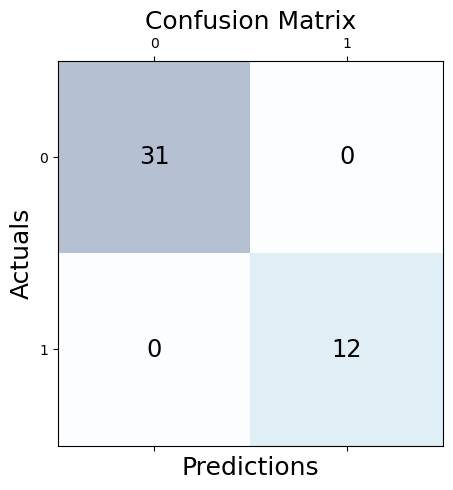

In [87]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

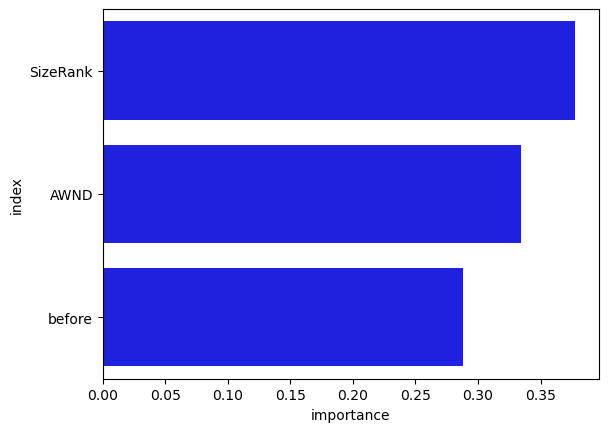

In [88]:
#seeing what features are most important to housing value
#Using feature importance 
feature_importances = xgb.feature_importances_

# Create a list of features
feature_list = list(X_boost.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

# Modeling All Housing
Let's run our model on our dataset with all our home values

## Model 1: All Housing

Let's see how our dataset with all data looks. 

In [91]:
all.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
4,Apalachicola,irma,9/10/2017,42.523469,71.58080,12877,52379.75722,63594.00344,21.409504,1
5,Apalachicola,irma,9/9/2017,29.012593,44.51431,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
9,Apalachicola,michael,10/9/2018,29.527080,46.97490,12877,65287.07867,76710.34737,17.496982,1


### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [92]:
#y is prediction variable 
#X is features 
y = all['increase']
X = all.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [93]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Training Data

In [94]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [95]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.704


In [96]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.101


### Testing Data

In [97]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [98]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_test))

Accuracy: 0.808


In [99]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_test, y_pred_test))

F1 Score: 0.000


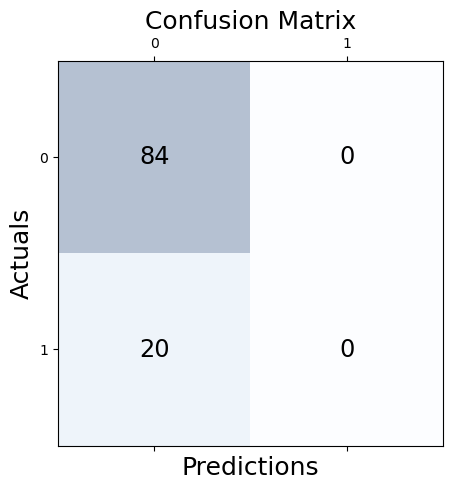

In [100]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

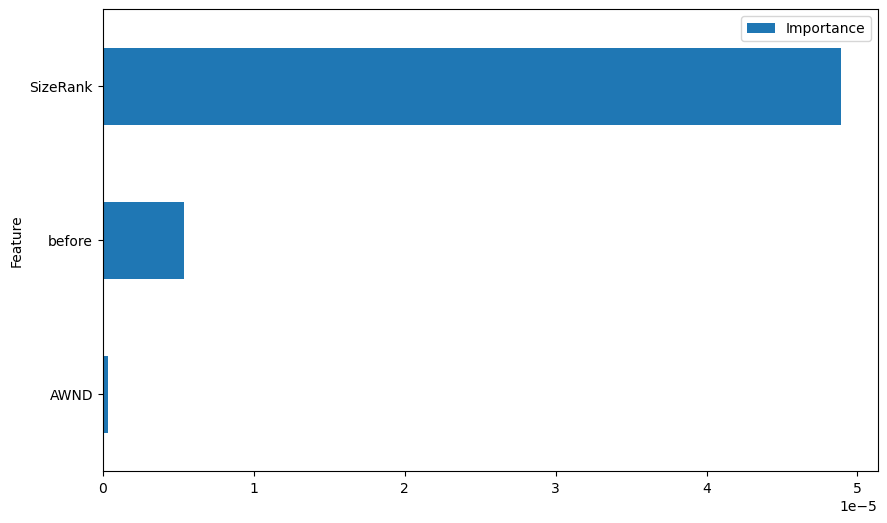

In [101]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Model 2: All Housing Without Colinear Variables and Scaling 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

In [102]:
all.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,irma,9/11/2017,46.527520,82.54161,12877,52379.75722,63594.00344,21.409504,1
4,Apalachicola,irma,9/10/2017,42.523469,71.58080,12877,52379.75722,63594.00344,21.409504,1
5,Apalachicola,irma,9/9/2017,29.012593,44.51431,12877,52379.75722,63594.00344,21.409504,1
6,Apalachicola,matthew,10/7/2016,24.024306,48.98811,12877,48548.85811,52980.36723,9.127937,0
9,Apalachicola,michael,10/9/2018,29.527080,46.97490,12877,65287.07867,76710.34737,17.496982,1


### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [103]:
#y is prediction variable 
#X is features 
y = all['increase']
X = all.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [104]:
#how do i know if it's even?
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

In [105]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Training Data

In [106]:
#fitting the model unto our training data
logreg.fit(X_train_std, y_train)
y_pred_train = logreg.predict(X_train_std)

In [107]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.717


In [108]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.150


### Testing Data

In [109]:
#fitting the model unto our test data
logreg.fit(X_test_std, y_test)
y_pred_test = logreg.predict(X_test_std)

In [110]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_test))

Accuracy: 0.808


In [111]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_test, y_pred_test))

F1 Score: 0.000


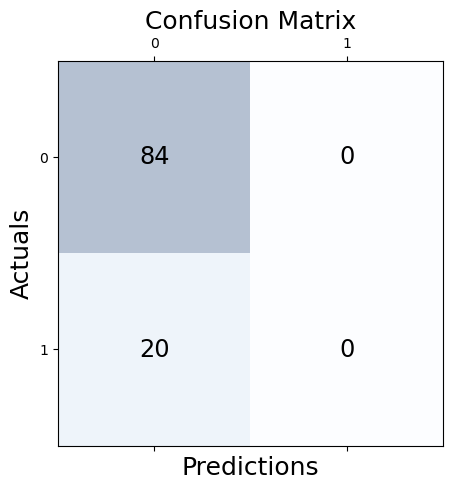

In [112]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

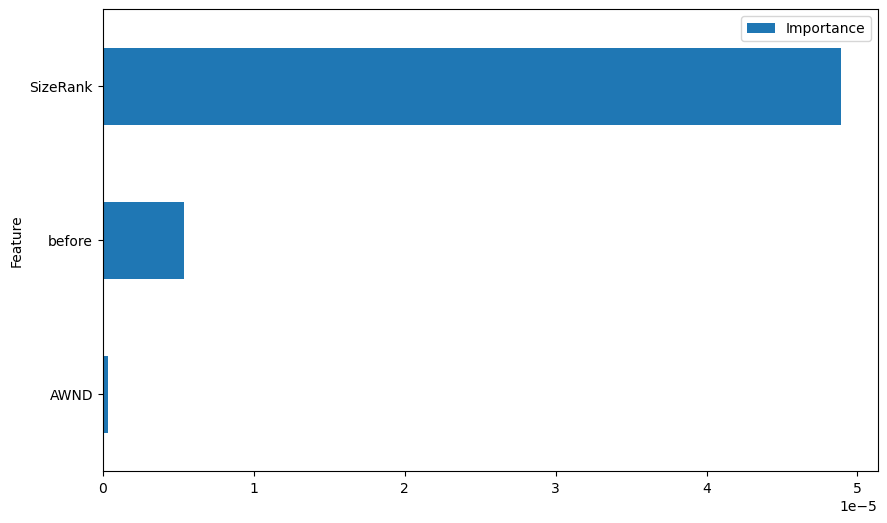

In [113]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## XGBoost

In [114]:
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
xgb = xgb.XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [115]:
#y is prediction variable 
#X is features 
y_boost = all['increase']
X_boost = all.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

In [116]:
#performing train test split 
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

In [117]:
xgb.fit(XG_X_train, XG_y_train);

In [118]:
y_pred_train = xgb.predict(XG_X_train)

In [119]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [120]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


In [121]:
xgb.fit(XG_X_test, XG_y_test);

In [122]:
y_pred_test = xgb.predict(XG_X_test)

In [123]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_test, y_pred_test))

Accuracy: 1.000


In [124]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_test, y_pred_test))

F1 Score: 1.000


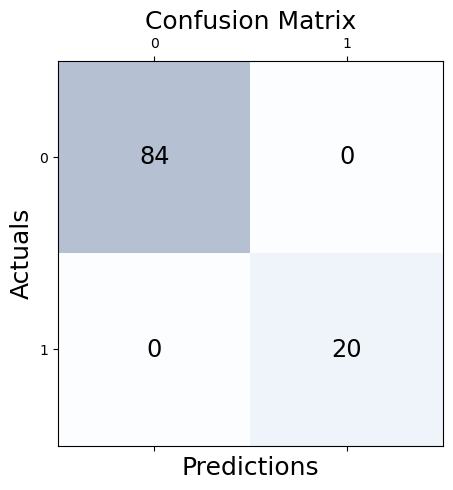

In [125]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

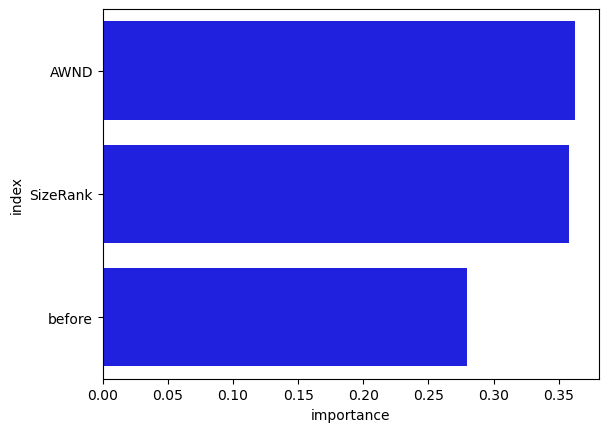

In [126]:
#seeing what features are most important to housing value
#Using feature importance 
feature_importances = xgb.feature_importances_

# Create a list of features
feature_list = list(X_boost.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

#### Precision 
"Precision measures the proportion of true positive predictions made by the model (i.e. the number of correct positive predictions divided by the total number of positive predictions). It is a useful metric for evaluating the model’s ability to avoid false positives."

#### Recall
"Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made. For example: If your machine learning model is trying to identify positive reviews, the recall score would be what percent of those positive reviews did your machine learning model correctly predict as a positive. In other words, it measures how good our machine learning model is at identifying all actual positives out of all positives that exist within a dataset. Recall is also known as sensitivity or the true positive rate."

"Recall score can be used in the scenario where the labels are not equally divided among classes. For example, if there is a class imbalance ratio of 20:80 (imbalanced data), then the recall score will be more useful than accuracy because it can provide information about how well the machine learning model identified rarer events."



In [ ]:
#Recall Score = TP / (FN + TP)
print('Recall: %.3f' % recall_score(y_test, y_pred))

#### Accuracy
Accuracy metrics only considers the number of correct predictions (true positives and true negatives) made by the model.

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [ ]:
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

In [ ]:
logreg.get_params(deep=True)

In [ ]:
#run XG Boost 
#get feature importance 
#backup data, what we could do in the future to yield different results 
##ould be worth it to have SMOTE in portofilio 
#could have dataset with or without SMOTE 
#change class weights to try to adjust for parameters (can be done in scikit learn)

#confusion matrix 
#false negatives and false positives 
#recall 
#continue to iterate, trying out other types of models 
#hyperparameters tuning doesn't need to be done except for best model 
#run best model on all datasets 
#shap to explore feature importance
#feature importance 

Faith Says: XG Boost and interpretation of data, make confusion matrix, if XG Boost performs better than do hyper parameter tuning on that, then do a tree based importance thing, or print out logistic regression formula to know best feature 

https://www.youtube.com/watch?v=FdnMWdICdRs
